In [1]:
%matplotlib inline
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.max_columns = 999
sns.set_style('white')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
workspace_dir  = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/Dataframes'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir        = '/Users/kanaaax/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'

#  Grab QSM QC dataframes 

In [2]:
# qsm dfs
def get_df(popname):
    df = pd.read_csv(os.path.join(pheno_dir, 'df_%s_qc.csv'%popname),index_col = 0)
    return df 

controls = get_df('controls')
patients = get_df('patients')

# clinical dfs
def return_cln_df(population):
    df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s.csv'%(population)), index_col=0)
    return df   

controls_cln = return_cln_df('controls')
patients_cln = return_cln_df('patients')

#  Define stat functions 

In [3]:
import math 
import statsmodels.api as sm
import scipy.stats as ss 
import statsmodels.formula.api as smf
from numpy import mean, std
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
from outliers import smirnov_grubbs as grubbs

def cohen_d(df1,df2, metabolite):
    x = df1[metabolite].dropna(axis=0)
    y = df2[metabolite].dropna(axis=0)
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

def detect_outlier_subjects(df,measure,m=3):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])
    for subject in df.index:
        if df.loc[subject][measure] > upper:
            print subject
        elif df.loc[subject][measure] < lower:
            print subject

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def calc_confidence_95(df1,df2, metabolite):
    import numpy as np, statsmodels.stats.api as sms
    X1 = df1[metabolite].dropna(axis=0)
    X2 = df2[metabolite].dropna(axis=0)
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    return cm.tconfint_diff(usevar='pooled')


#  Make stat tables 

In [4]:
def make_statistical_comparison(df_controls, df_patients, stat, measures):
    df_controls['Group'] = 0
    df_patients['Group'] = 1
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D','CI_95', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)
    
    df = pd.concat([df_controls, df_patients])
    for measure in measures:
        if stat == 'MR':
            formula = '%s ~ Group + Age + Gender + EFC_MAG + QI1_MAG'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],3)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        ci95 = calc_confidence_95(df_controls, df_patients, measure)
        xval = 1
        npr  = 2
        dfs.ix['N'][measure] = len(df_controls[measure].dropna()), len(df_patients[measure].dropna())
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure].dropna(), df_patients[measure].dropna())[1],5)
        dfs.ix['KS'][measure] = np.round(ks_2samp((df_controls[measure].dropna()), 
                                                  (df_patients[measure].dropna()))[1], 5)
        dfs.ix['KS_C'][measure] = np.round(kstest((df_controls[measure].dropna()), 'norm')[1],5)
        dfs.ix['KS_P'][measure] = np.round(kstest((df_patients[measure].dropna()), 'norm')[1],25)
        dfs.ix['D'][measure]    = cohen_d(df_controls, df_patients,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(df_controls, df_patients,measure),2)
        dfs.ix['CI_95'][measure]= '%s to %s'%(np.round(ci95[0],2), np.round(ci95[1],5))
        dfs.ix['Statistic'][measure]= np.round(t_val,4)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort_values('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 

# Compare QSM values for combinations of nuclei (Mann Whitney Wilcoxon test)

In [5]:
measures  = ['BG', 'BS', 'ALL']

X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures)
X#.drop(['Levene', 'KS', 'KS_C', 'KS_P'],axis = 1)

BG p = 0.004
BS p = 0.011
ALL p = 0.006


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
BG,"(26, 23)",24.74±14.59,13.53±13.2,0.90264,0.0223,0,1.933e-15,0.79,3.01 to 19.41642,167,0.00421,0.008445,True
ALL,"(26, 23)",70.49±18.45,56.65±18.17,0.729,0.00182,0,0,0.74,3.07 to 24.61333,172,0.00563,0.008445,True
BS,"(26, 23)",116.24±25.05,99.77±26.3,0.9297,0.02398,0,0,0.63,1.4 to 31.55438,184,0.0109,0.0109,True


# Compare QSM values for specific nuclei   (Mann Whitney Wilcoxon test)


In [6]:
measures = [ 'Caud_Puta' ,'Pall', 'RN', 'SN', 'STN', 'DN']

X, XX = make_statistical_comparison(controls, patients, 'MW', measures = measures)
X#.drop(['Levene', 'KS', 'KS_C', 'KS_P'],axis = 1)

Caud_Puta p = 0.009
Pall p = 0.021
SN p = 0.032
STN p = 0.003
DN p = 0.016


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,CI_95,Statistic,p_val,p_fdr,sig
STN,"(26, 23)",69.3±33.16,42.04±31.08,0.70772,0.01997,0,0,0.83,8.33 to 46.19301,159,0.0026,0.0156,True
Caud_Puta,"(26, 23)",17.48±15.65,6.38±13.42,0.66592,0.04969,0,1.05439e-08,0.75,2.5 to 19.72127,180,0.0088,0.0264,True
DN,"(26, 23)",72.13±31.24,51.48±39.37,0.4134,0.0223,0,0,0.57,-0.1 to 41.40103,191,0.01564,0.03128,True
Pall,"(26, 23)",87.58±19.35,75.17±19.9,0.89417,0.20526,0,0,0.62,0.88 to 23.94505,197,0.02101,0.031515,True
SN,"(26, 23)",123.99±24.66,110.04±31.19,0.7203,0.08543,0,0,0.49,-2.47 to 30.35744,206,0.03193,0.038316,True
RN,"(26, 23)",116.32±46.61,97.88±34.5,0.18717,0.14067,0,0,0.44,-5.89 to 42.76204,232,0.09139,0.09139,False


# Plot QSM data 

# Compare Ferritin values for available data between patients and controls 

In [7]:
##############################################
#  Grab Ferritin data from clinical dataframes 
##############################################

Ferr_C = reject_outliers(controls['CLN_Ferritin'].dropna(),3)
Ferr_P = reject_outliers(patients['CLN_Ferritin'].dropna(),3)


print 'N=',len(Ferr_C), 'Controls Ferritin = ', np.round(np.mean(Ferr_C),2), '±', np.round(np.std(Ferr_C),2)
print 'N=',len(Ferr_P), 'Patients Ferritin = ', np.round(np.mean(Ferr_P),2), '±', np.round(np.std(Ferr_P),2)
print ''
print 'Kolmogrov-Smirnov test of Gaussian Distribution'
print '- Controls t-stat/pval=', kstest(preprocessing.scale(Ferr_C), 'norm')
print '- Patients t-stat/pval=:', kstest(preprocessing.scale(Ferr_P), 'norm')
print '- Two Sample t-stat/pval', ks_2samp(preprocessing.scale(Ferr_C), preprocessing.scale(Ferr_P))
print ''
print 'Degrees of freedom =',len(Ferr_C+Ferr_P)-2
print ''
print 'Levenes test of equal variance =',levene(Ferr_C, Ferr_P, center='median')
print ''
print 'Welches Test =', ttest_ind(Ferr_C, Ferr_P, equal_var = False)


N= 18 Controls Ferritin =  196.2 ± 151.26
N= 15 Patients Ferritin =  85.56 ± 48.87

Kolmogrov-Smirnov test of Gaussian Distribution
- Controls t-stat/pval= KstestResult(statistic=0.17492958886477183, pvalue=0.5950690687759914)
- Patients t-stat/pval=: KstestResult(statistic=0.17409332694649926, pvalue=0.7224905557195884)
- Two Sample t-stat/pval Ks_2sampResult(statistic=0.1444444444444445, pvalue=0.9912553407545137)

Degrees of freedom = 31

Levenes test of equal variance = LeveneResult(statistic=10.867083097226889, pvalue=0.002459306300004549)

Welches Test = Ttest_indResult(statistic=2.841376898389472, pvalue=0.009727435781744419)


# plot ferritin data 

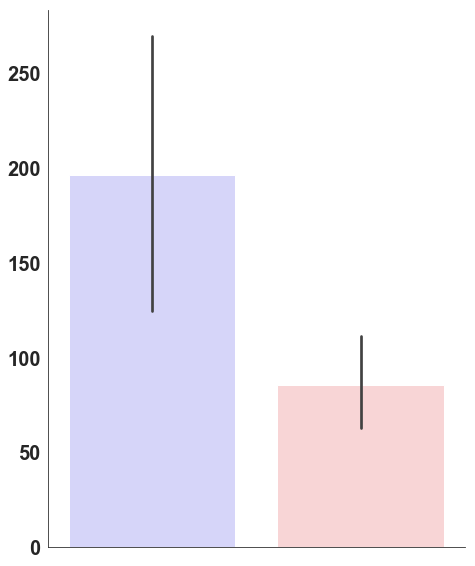

In [16]:
#### pd.DataFrame(columns=['Ferritin', 'Group'])
fc = pd.DataFrame(Ferr_C)
fp = pd.DataFrame(Ferr_P)
fc['group']   = 'Controls'
fp['group']   = 'Patients'
FERR =pd.concat([fc,fp])
#xpal = ["#1300ff", "#87d6e9"]
xpal =['#b5b8ff','#ffb3b9']
xpal= ['#d0cfff', '#fecfd0']

fig, ax = plt.subplots(1)
fig.set_size_inches([7,8])
#g = sns.boxplot(x="group", y="CLN_Ferritin", data=FERR,  palette=xpal)
g = sns.barplot(x="group", y="CLN_Ferritin", data=FERR,  palette=xpal)
#plt.xlim(-0.75, 1.75)
#plt.ylim(0,270)
# Finalize the plot
sns.despine(bottom=False)
#plt.setp(fig.axes, yticks=[])
plt.setp(fig.axes, xticks=[])
ax.tick_params(axis='y', labelsize=25)
plt.tight_layout(h_pad=3)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=20, weight='bold')
fig.savefig(os.path.join(save_fig_dir,'FERR_comparison.png'), bbox_inches='tight', transparent = 1, dpi = 500)

In [9]:
sns.violinplot?

Signature: sns.violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.8, inner='box', split=False, dodge=True, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, ax=None, **kwargs)
Docstring:
Draw a combination of boxplot and kernel density estimate.

A violin plot plays a similar role as a box and whisker plot. It shows the
distribution of quantitative data across several levels of one (or more)
categorical variables such that those distributions can be compared. Unlike
a box plot, in which all of the plot components correspond to actual
datapoints, the violin plot features a kernel density estimation of the
underlying distribution.

This can be an effective and attractive way to show multiple distributions
of data at once, but keep in mind that the estimation procedure is
influenced by the sample size, and violins for relatively small samples
might look misleadingly smooth

In [10]:
df = pd.read_csv('/Users/kanaaax/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/OLD/JULY29/patients_qc.csv')

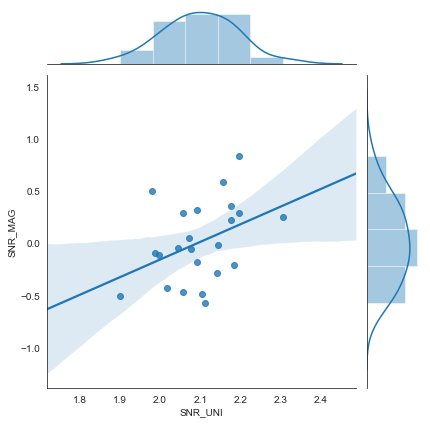

In [11]:
sns.jointplot(df.SNR_UNI, df.SNR_MAG, kind = 'reg')

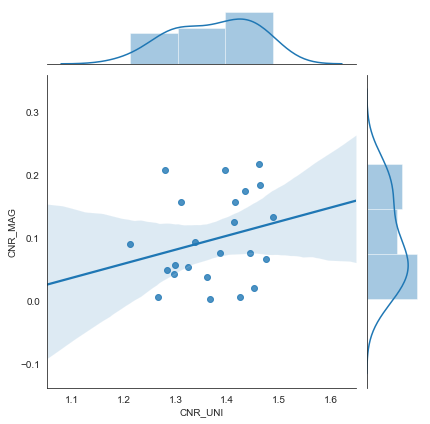

In [12]:
sns.jointplot(df.CNR_UNI, df.CNR_MAG, kind = 'reg')

In [13]:
patients

,Age,Gender,Group,SNR_MAG,CNR_MAG,FBER_MAG,EFC_MAG,FWHM_MAG,QI1_MAG,R_Caud,R_Puta,R_Pall,R_Amyg,R_Hipp,R_Accu,R_Thal,L_Caud,L_Puta,L_Pall,L_Amyg,L_Hipp,L_Accu,L_Thal,L_BG,R_BG,R_RN,R_SN,R_STN,R_DN,R_GPi,R_GPe,L_RN,L_SN,L_STN,L_DN,L_GPi,L_GPe,L_BS,R_BS,THA7_0,THA7_1,THA7_2,THA7_3,THA7_4,THA7_5,THA7_6,THA7_7,STR3_MOTOR,STR3_LIMBIC,STR3_EXEC,STR7_MOTOR_C,STR7_MOTOR_R,STR7_LIMBIC,STR7_EXECUTIVE,STR7_PARIETAL,STR7_OCCIPITAL,STR7_TEMPORAL,MRS_ACC,MRS_THA,MRS_STR,MRSc_ACC,MRSc_THA,MRSc_STR,GM,WM,CSF,Caud,Puta,Pall,Amyg,Hipp,Accu,Thal,SN,STN,RN,DN,GPi,GPe,BG,BS,L_Caud_Puta,R_Caud_Puta,Caud_Puta,ALL,QC_PCA,Chi_PCA,CLN_Age,CLN_Birthday,CLN_YGTSS_Total_Tic_Score,CLN_YGTSS_Motoric_Score,CLN_YGTSS_Vocal_Score,CLN_YGTSS_Total_Score_incl_Impairment,CLN_DSM4_ADHD_Score,CLN_DSM4_Attention,CLN_DSM4_Hyperactivity,CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score,CLN_DSM4_clinically_significant_ADHD,CLN_OCIR_Wash,CLN_OCIR_WASH_clinically_significant,CLN_OCIR_Thoughts,CLN_OCIR_Thoughts_clinically_significant,CLN_OCIR_Hoarding,CLN_OCIR_Hoarding_clinically_significant,CLN_OCIR_Tidy,CLN_OCIR_Tidy_clinically_significant,CLN_OCIR_Mental_Neutralisation,CLN_OCIR_Mental_Neutralisation_clinically_significant,CLN_OCIR_Control,CLN_OCIR_Control_clinically_significant,CLN_OCIR_total_score,CLN_YBOCS_obsessions,CLN_YBOCS_obsessions_sig,CLN_YBOCS_compulsions,CLN_YBOCS_compulsions_sig,CLN_YBOCS_Totalscore_Items_1to10,CLN_YBOCS_Totalscore_Items_1to10_clinically_significant,CLN_BDI12,CLN_BDI12_clinically_significant,CLN_BDI12_severity,CLN_MADRS,CLN_MADRS_clinically_significant,CLN_MADRS_severity,CLN_BAI,CLN_BAI_clinically_significant,CLN_BAI_severity,CLN_puts,CLN_puts_meaning,CLN_qol_score,CLN_qol_scale,CLN_qol_clinical meaning,CLN_RVTRS,CLN_Diag_ADHD,CLN_Diag_OCD,CLN_Diag_Depression,CLN_Diag_Anxiety,CLN_Diag_AQ,CLN_medication,CLN_THC_occasional,CLN_Ferritin,CLN_Unnamed: 54,CLN_Unnamed: 55,CLN_Unnamed: 56,Diagnosis
BE9P,18,0,1,2.615788,0.138203,6.980852,0.625762,3.79525,0.314843,-5.605,-36.403,86.695,-35.032,-22.898,-51.548,-42.211,3.846,-35.613,90.525,-42.220,-14.546,-42.468,-47.179,-1.270,-7.023,49.006,91.236,9.375,21.780,121.505,115.656,44.792,85.533,9.722,44.387,115.069,103.300,67.151,76.115,-34.575,-34.575,-34.747,-41.450,-55.880,-52.882,-39.642,-32.371,-24.692,-36.809,-21.542,-24.942,-57.659,-35.359,-21.552,-10.963,-55.875,-113.901,-49.701,-46.518,-20.022,-52.040,-48.523,-12.992,-33.735,-40.758,-24.059,-0.8795,-36.0080,88.6100,-38.6260,-18.7220,-47.0080,-44.6950,88.3845,9.5485,46.8990,33.0835,118.2870,109.4780,-4.1465,71.6330,-15.8835,-21.0040,-18.44375,33.74325,0.198263,0.116567,18,7/9/96,3,3,0,3,15,1,1,51.0,no,2,no,0,no,3,no,3,no,0,no,2,no,10,0,no,0,no,0,no,8,no,-,0,no,no symptoms,12,yes,mild,10,mild intensity,5,60,medium happy,6,0,0,0,0,0,other-anxiolytic,0,86.07,BE9P,Be9p141115,NaN,GTS
HJEP,21,0,1,2.957837,0.162067,8.298943,0.631597,3.44716,0.354446,20.768,3.985,82.374,-46.817,-35.209,-21.791,-28.529,20.583,4.765,68.865,-30.371,-22.616,-24.865,-29.921,17.157,19.676,51.422,109.946,34.257,21.931,99.052,104.299,50.131,110.109,51.811,38.432,57.353,68.213,89.282,91.927,-36.386,-36.386,-26.193,-3.265,-41.341,-48.995,-2.660,-24.576,10.999,-11.685,6.724,-2.946,-42.625,-11.153,6.725,36.567,5.791,-108.499,-49.033,-47.110,-6.831,-47.214,-49.974,-1.202,-22.893,-29.488,-16.976,20.6755,4.3750,75.6195,-38.5940,-28.9125,-23.3280,-29.2250,110.0275,43.0340,50.7765,30.1815,78.2025,86.2560,18.4165,90.6045,12.6740,12.3765,12.52525,54.51050,0.180925,0.136946,21,9/15/92,14,14,0,71,12,1,1,57.0,no,0,no,2,no,3,no,3,no,3,no,2,no,13,2,no,4,no,6,no,20,yes,medium,3,no,no symptoms,8,yes,mild,26,high intensity,23,40,unhappy,12,0,1,0,1,0,naive,0,76.43,HJEP,Hjep140906,NaN,GTS_OCD
RMJP,22,1,1,2.507093,0.064413,12.257068,0.559070,4.10860,0.249278,15.750,-19.818,69.418,-40.511,-29.881,-77.344,-46.073,26.137,-4.954,80.026,-53.603,-30.325,-37.873,-41.973,18.318,4.810,101.286,124.871,42.675,62.705,87.745,109.624,76.712,114.080,14.365,43.952,75.478,101.168,93.291,111.566,-65.637,-65.637,-63.812,-

In [17]:
lemon = pd.read_csv(os.path.join(pheno_dir, 'df_raw_lemon.csv'), index_col=0)
lemon_cln =pd.read_csv(os.path.join(pheno_dir, 'df_lemon_ferritin.csv'),index_col=0)
lemon_cln.index = [i.upper() for i in lemon_cln.index]
lemon['ferritin'] = lemon_cln.Ergebnis

x = 'ferritin'
y = 'Caud_Puta'

lemon = lemon.drop([i for i in lemon.columns if i not in regressorsx + [x,y]], axis=1).dropna()


NameError: name 'regressorsx' is not defined